## Librerias

In [82]:
import pandas as pd

from sqlalchemy import create_engine

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


## Preparación de los Datos

In [7]:
# Leer los datos de la carpeta
data = pd.read_csv('./data/raw_tweets.csv')

In [8]:
# seleccionar columnas relevantes 
data.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'time',
       'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'language',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [15]:
df = data[['id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet','video']]

In [48]:
# cambiar formato a date-time
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = pd.to_datetime(df['date'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## visión general

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              80 non-null     int64 
 1   created_at      80 non-null     object
 2   date            80 non-null     object
 3   time            80 non-null     object
 4   timezone        80 non-null     int64 
 5   user_id         80 non-null     int64 
 6   username        80 non-null     object
 7   name            80 non-null     object
 8   tweet           80 non-null     object
 9   language        80 non-null     object
 10  mentions        80 non-null     object
 11  urls            80 non-null     object
 12  photos          80 non-null     object
 13  replies_count   80 non-null     int64 
 14  retweets_count  80 non-null     int64 
 15  likes_count     80 non-null     int64 
 16  hashtags        80 non-null     object
 17  cashtags        80 non-null     object
 18  link        

In [17]:
df.describe()

,id,timezone,user_id,replies_count,retweets_count,likes_count,video
count,8.000000e+01,80.0,8.000000e+01,80.000000,80.000000,80.000000,80.000000
mean,1.518349e+18,200.0,5.836056e+17,0.250000,0.737500,2.462500,0.462500
std,5.747449e+15,0.0,5.749044e+17,0.720408,1.166448,3.035419,0.501737
min,1.507059e+18,200.0,1.609031e+06,0.000000,0.000000,0.000000,0.000000
25%,1.515942e+18,200.0,2.273279e+08,0.000000,0.000000,0.000000,0.000000
50%,1.517419e+18,200.0,7.346749e+17,0.000000,0.000000,1.000000,0.000000
75%,1.522567e+18,200.0,1.162694e+18,0.000000,1.000000,4.000000,1.000000
max,1.528697e+18,200.0,1.528650e+18,5.000000,5.000000,15.000000,1.000000


In [18]:
df['username'].nunique()


38

In [20]:
df['timezone'].nunique()

1

In [19]:
df['language'].nunique()

3

## Analysis Exploratorio

#### ¿Cuál es el tweet con mayor repercusión social?

In [21]:
# crear columna de repercusión social total 
df['total_effect'] = df['retweets_count']+df['replies_count']+df['likes_count']

# ordenar segun la repercusion social 
top_tweets = df.sort_values('total_effect', ascending = False)

# sacar tweet con mayor repercusion social 
top_tweets.iloc[0]['tweet']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


'De los 21, hay 7 desarrolladoras de @Adalab_Digital, 4 de @4GeeksAcademyES, 2 de @CodenotchMAD, 1 de @socratech_ , 1 de @TheBridge_Tech, 1 de @ITAcademy, 1 de @nebulova_es y de FP-DAW y autodidactas.'

In [24]:
top_tweets.iloc[0]['replies_count']

3

In [23]:
top_tweets.iloc[0]['retweets_count']

3

In [22]:
top_tweets.iloc[0]['likes_count']

12

#### ¿Cuál es el usuario que más menciona a la escuela?

In [25]:
# mirar quien es el que mas menciona a la escuela

# crear un diccionario
freq_dict = defaultdict(int)

all_users = df['user_id']

# hacer un conteo de veces que aparece cada usuarie
for user in all_users:
    freq_dict[user] += 1

# crear data frame del diccionario y ordenar 
sorted_users = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
sorted_users.columns = ["user", "user_tweet_count"]

In [28]:
# sacar el nombre para poder polotear
users_actual_name = []
for i in range(0,len(sorted_users)):
    aux = df[df['user_id']==sorted_users.iloc[i]['user']]
    users_actual_name.append(aux.iloc[0]['username'])
    
sorted_users['name'] = users_actual_name

In [40]:
plt.style.use('default')

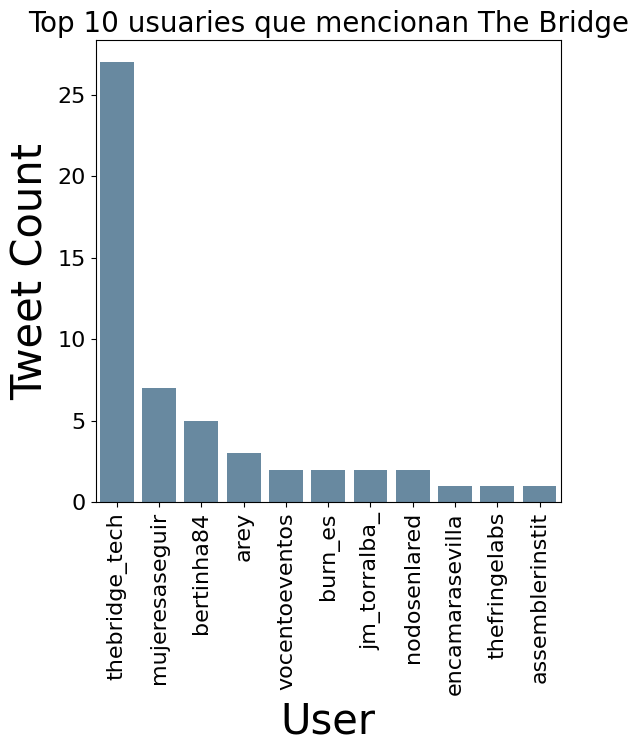

In [46]:
# diagrama de barras simple 
plt.figure(figsize=(6,6))
# de los top 10 
sns.barplot(x='name', y='user_tweet_count', data=sorted_users.loc[:10,:], color='#5F8BA9')
plt.title("Top 10 usuaries que mencionan The Bridge", fontsize=20)
plt.ylabel('Tweet Count', fontsize=30)
plt.xlabel('User', fontsize=30)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.show()

### ¿En qué mes se concentra el mayor número de tweets?

In [50]:
df['month'] = list(map(lambda x: x.month, df['created_at']))

aux = df.groupby('month')[['tweet']].count().sort_values(by='tweet', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
print(aux)

       tweet
month       
4         49
5         23
3          8


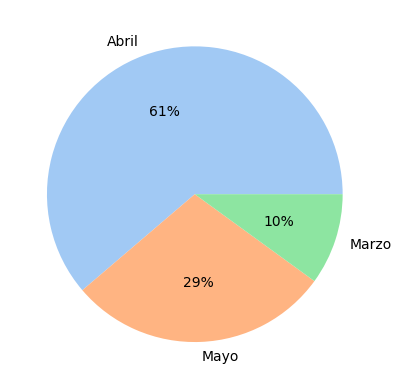

In [56]:
labels = ['Abril', 'Mayo', 'Marzo']
# colores
colors = sns.color_palette('pastel')[0:5]
plt.pie(aux['tweet'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

#### ¿Qué palabras son más frecuentes?


In [57]:
text = ' '.join(df['tweet'])

In [61]:
text = text.replace('TheBridge_Tech', ' ')

In [73]:
# que palabras son mas frecuentes

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40):
    
    stopwords = ['y','el','de','la','a', 'que','en','lo','para','por','los','las','un','tu','del','me','esa']

    wordcloud = WordCloud(
                    background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
                    
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)

    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                            'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

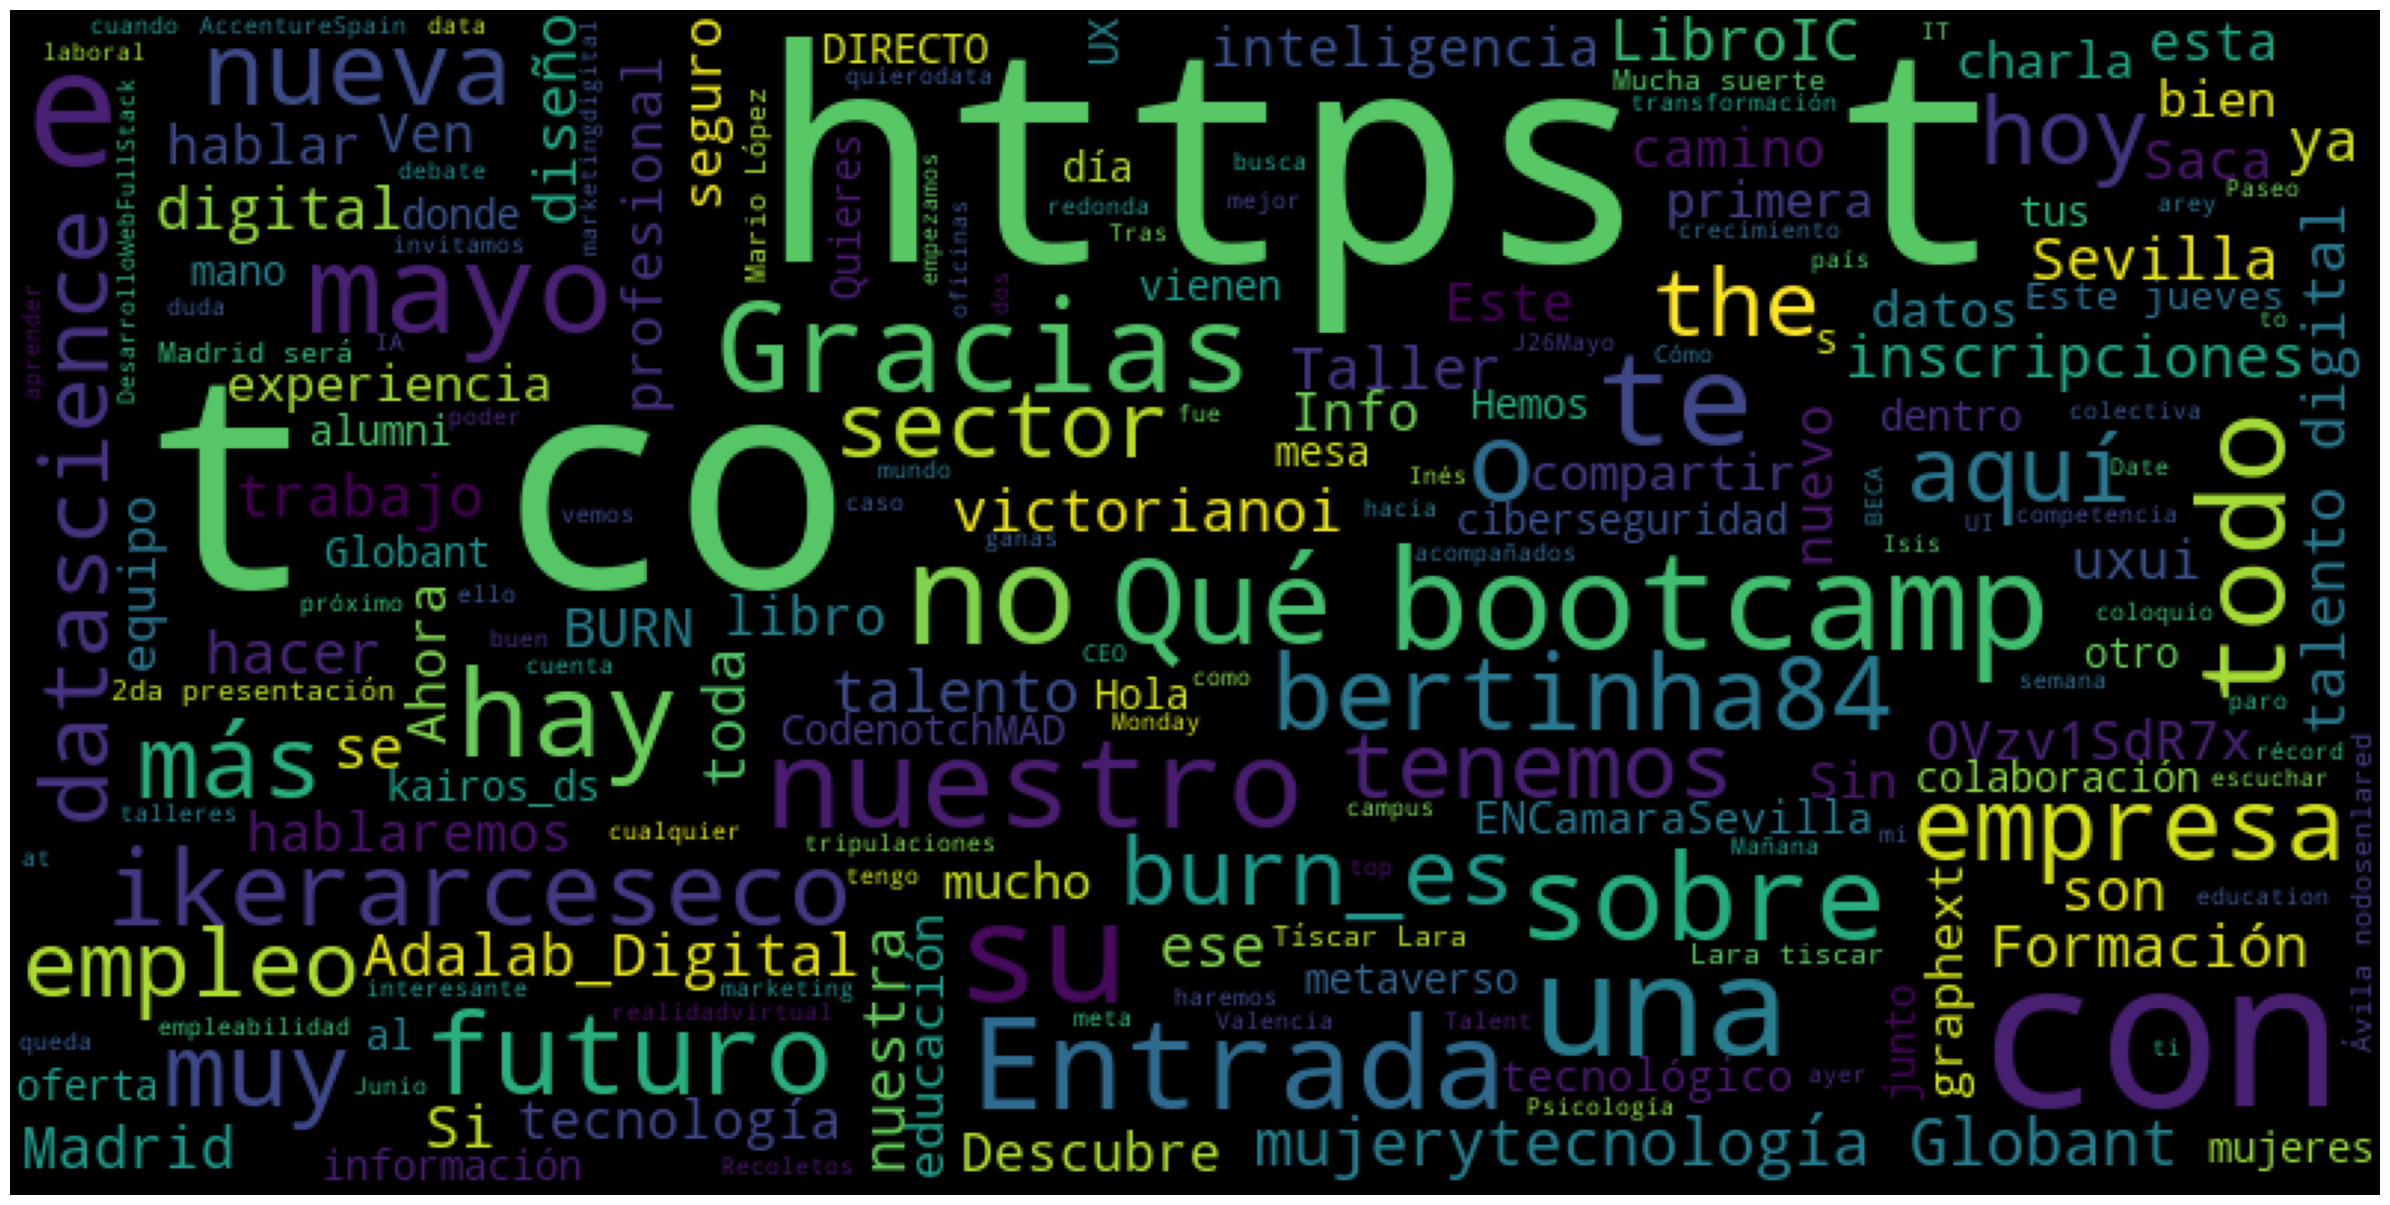

In [74]:
plot_wordcloud(text)

In [75]:
Counter(" ".join(df["tweet"]).split()).most_common(100)[:10]

[('de', 132),
 ('en', 78),
 ('@TheBridge_Tech', 50),
 ('el', 47),
 ('y', 44),
 ('la', 39),
 ('que', 38),
 ('a', 27),
 ('un', 25),
 ('con', 25)]

In [92]:
text = text.translate(str.maketrans('', '', string.punctuation))
nltk.download('stopwords')
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1076)>


In [93]:
Counter(tokens_without_sw).most_common(100)[:10]

[('La', 9),
 ('Globant', 8),
 ('▪️', 8),
 ('Madrid', 7),
 ('talento', 7),
 ('mujerytecnología', 7),
 ('En', 6),
 ('mayo', 6),
 ('bootcamp', 6),
 ('ikerarceseco', 6)]

### ¿Qué tipo de correlación matemática encuentras entre las métricas públicas?

<AxesSubplot:>

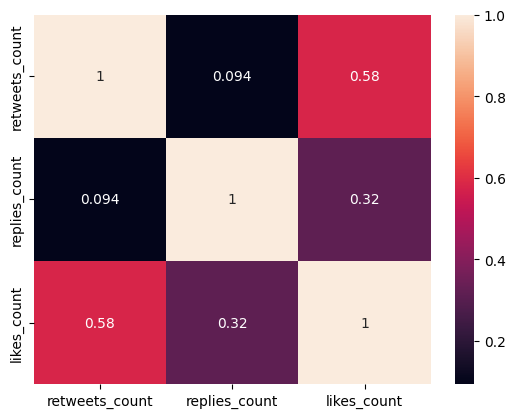

In [95]:
metrics = df[['retweets_count','replies_count','likes_count']]

sns.heatmap(metrics.corr(), annot=True)

## Entre los retweets y los likes hay un poquito de relacion pero no mucho 